In [1]:
import numpy as np
import pandas as pd 

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Setting for full table display
pd.set_option('display.max_columns', None)

In [5]:
# Reading a Source File
file_path = r"C:\Users\jiao_\Desktop\marketing_campaign.xlsx"
data = pd.read_excel(file_path, engine='openpyxl')

In [6]:
data

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,2014-06-10,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,2014-01-24,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,3,11,0


In [7]:
# Rename columns for convenience
data.rename(columns={'MntWines': 'Wines',
                     'MntFruits': 'Fruits',
                     'MntMeatProducts': 'Meat',
                     'MntFishProducts': 'Fish',
                     'MntSweetProducts': 'Sweet',
                     'MntGoldProds': 'Gold',
                     'NumDealsPurchases': 'Discount_Purchases',
                     'NumWebPurchases': 'Web_Purchases',
                     'NumCatalogPurchases': 'Catalog_Purchases',
                     'NumStorePurchases': 'Store_Purchases'}, inplace=True)

In [8]:
#transform the categorical features of the fields Education and Marital_Status
le = LabelEncoder()
education_label = le.fit_transform(data['Education'])
data['Education'] = education_label

In [9]:
marital_staus_label = le.fit_transform(data['Marital_Status'])
data['Marital_Status'] = marital_staus_label

In [10]:
#check out the value of Z_CostContact, Z_Revenue
data[['Z_CostContact', 'Z_Revenue']].describe()

,Z_CostContact,Z_Revenue
count,2240.0,2240.0
mean,3.0,11.0
std,0.0,0.0
min,3.0,11.0
25%,3.0,11.0
50%,3.0,11.0
75%,3.0,11.0
max,3.0,11.0


In [11]:
#remove Z_CostContact, Z_Revenue
data.drop(columns=['Z_CostContact', 'Z_Revenue'], inplace=True)

In [12]:
#change the wrong format of Dt_Customer 
data['Dt_Customer']=pd.to_datetime(data['Dt_Customer'])

In [13]:
# transform the Dt_Customer field
#convert it to a normal date format, and then divide by day, month, year
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], dayfirst=True)

data['Day'] = data['Dt_Customer'].apply(lambda x: x.day)
data['Month'] = data['Dt_Customer'].apply(lambda x: x.month)
data['Year'] = data['Dt_Customer'].apply(lambda x: x.year)

data.drop(columns='Dt_Customer', inplace=True)

In [14]:
#Calculate the average in each group Education and fill in the gaps with these values
mean_income = round(data.groupby('Education')['Income'].mean(), 2)
data['Income'] = data.apply(lambda row: mean_income[row['Education']] 
                        if np.isnan(row['Income']) 
                        else row['Income'], axis=1)

In [15]:
# amount the customer spent on all product categories in the last 2 years
data['Total_Products'] = data['Wines'] + data['Fruits'] + data['Meat'] + \
                         data['Fish'] + data['Sweet'] + data['Gold']

In [16]:
# number of accepted offers for all campaigns
data['Total_Accepted'] = data['AcceptedCmp1'] + data['AcceptedCmp2'] + \
                         data['AcceptedCmp3'] + data['AcceptedCmp4'] + data['AcceptedCmp5']

In [17]:
# number of customer purchases
data['Total_Purchases'] = data['Discount_Purchases'] + data['Web_Purchases'] + \
                        data['Catalog_Purchases'] + data['Store_Purchases']

In [18]:
# number of children
data['Children'] = data['Kidhome'] + data['Teenhome']

In [19]:
# is the client a parent or not (1 - yes, 0 - no)
data['Parents'] = np.where(data['Children'] > 0, 1, 0)

In [20]:
data

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweet,Gold,Discount_Purchases,Web_Purchases,Catalog_Purchases,Store_Purchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Day,Month,Year,Total_Products,Total_Accepted,Total_Purchases,Children,Parents
0,5524,1957,2,4,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,4,9,2012,1617,0,25,0,0
1,2174,1954,2,4,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,8,3,2014,27,0,6,2,1
2,4141,1965,2,5,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,21,8,2013,776,0,21,0,0
3,6182,1984,2,5,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,10,2,2014,53,0,8,1,1
4,5324,1981,4,3,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,19,1,2014,422,0,19,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,2,3,61223.0,0,1,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,0,13,6,2013,1341,0,18,1,1
2236,4001,1946,4,5,64014.0,2,1,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,0,10,6,2014,444,1,22,3,1
2237,7270,1981,2,2,56981.0,0,0,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,0,25,1,2014,1241,1,19,0,0
2238,8235,1956,3,5,69245.0,0,1,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,0,24,1,2014,843,0,23,1,1


Second Step: Scale the data

In [21]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

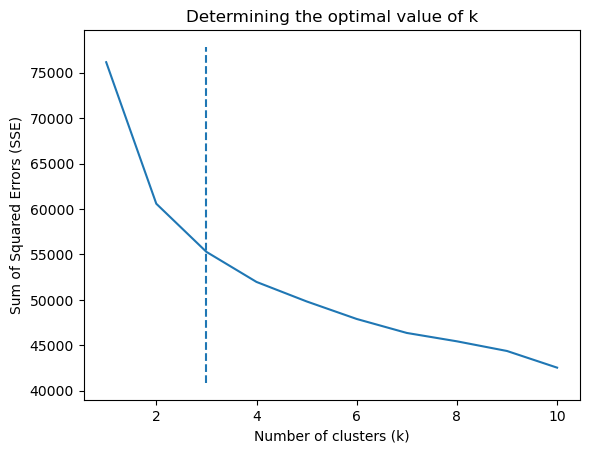

Optimal number of clusters (k): 3


In [22]:
# determining the optimal value of K
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    sse.append(kmeans.inertia_)
    
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
optimal_k = kl.elbow

# result visualization
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Determining the optimal value of k')
plt.plot(range(1, 11), sse)
plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

print("Optimal number of clusters (k):", optimal_k)

In [23]:
# client clustering with K-means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_scaled)
data['Cluster'] = kmeans.labels_

In [24]:
# Analyze the resulting groups/clusters
cluster_sizes = data['Cluster'].value_counts()

In [25]:
# Let's see how many clients are in each group/cluster
for cluster in range(3):
    print(f"Group {cluster} contains {cluster_sizes[cluster]} clients")

Group 0 contains 1078 clients
Group 1 contains 510 clients
Group 2 contains 652 clients


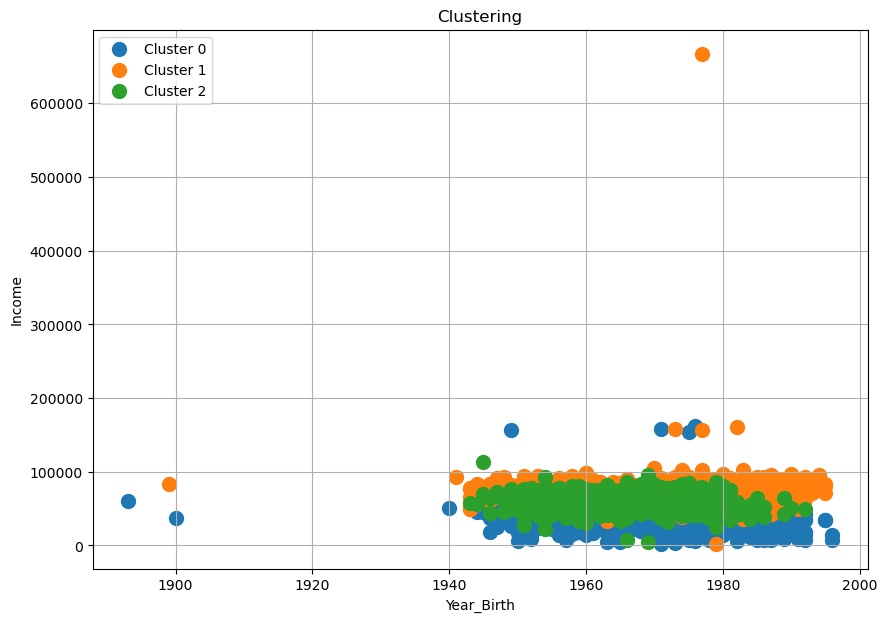

In [26]:
fig, ax = plt.subplots(figsize=(10, 7))  
legend = []
x_lable='Year_Birth'
y_lable='Income'

ax.set_xlabel(x_lable)             
ax.set_ylabel(y_lable)  
plt.title('Clustering')

for c, rows in data.groupby('Cluster'):
    plt.scatter(rows[x_lable], rows[y_lable], s = 100)
    legend.append("Cluster %s" % c)
    plt.legend(legend, loc="upper left")
plt.grid()
plt.show()

In [27]:
data.shape

(2240, 35)

In [28]:
# remove noise
data = data[(data['Year_Birth'] > 1900) & (data['Income'] < 600_000)]

In [29]:
data.shape

(2236, 35)

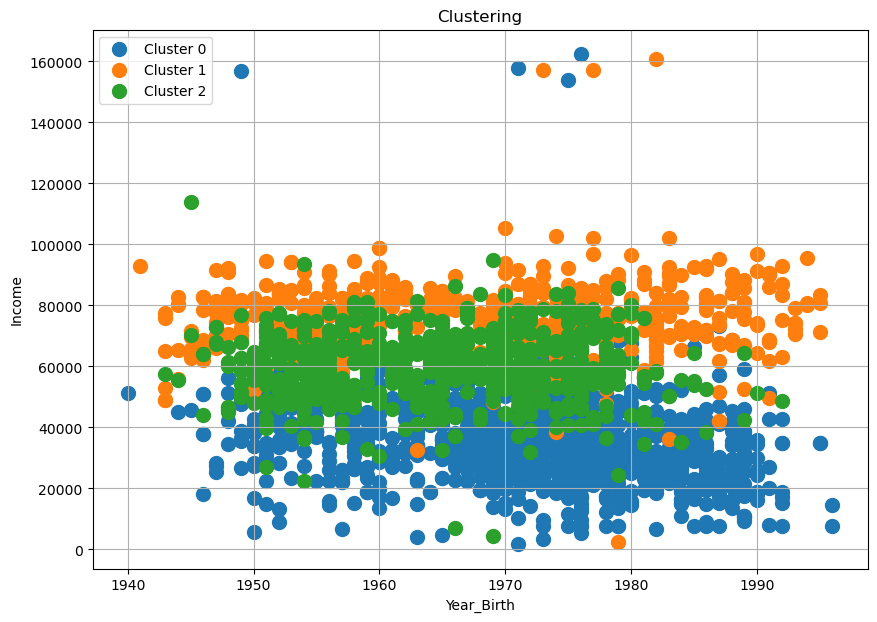

In [30]:
fig, ax = plt.subplots(figsize=(10, 7))  
legend = []
x_lable='Year_Birth'
y_lable='Income'
ax.set_xlabel(x_lable)             
ax.set_ylabel(y_lable)  
plt.title('Clustering')
for c, rows in data.groupby('Cluster'):
    plt.scatter(rows[x_lable], rows[y_lable], s = 100)
    legend.append("Cluster %s" % c)
plt.legend(legend, loc="upper left")
plt.grid()
plt.show()

In [31]:
cluster_means = data.groupby('Cluster').mean()
cluster_means

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweet,Gold,Discount_Purchases,Web_Purchases,Catalog_Purchases,Store_Purchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Day,Month,Year,Total_Products,Total_Accepted,Total_Purchases,Children,Parents
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5622.112454,1971.314126,2.287175,3.720260,35666.170623,0.776022,0.460967,49.397770,46.345725,5.066914,24.347584,7.536245,5.213755,15.768587,2.079926,2.184944,0.584572,3.283457,6.421933,0.070632,0.012082,0.000000,0.000929,0.001859,0.011152,0.089219,15.861524,6.278810,2013.126394,104.278810,0.085502,8.132900,1.236989,0.876394
1,5691.458661,1968.547244,2.411417,3.767717,76506.749252,0.023622,0.043307,49.318898,631.811024,64.190945,479.435039,95.785433,66.147638,74.539370,1.129921,4.887795,6.082677,8.244094,2.665354,0.090551,0.151575,0.301181,0.244094,0.041339,0.005906,0.328740,15.399606,6.429134,2013.043307,1411.909449,0.828740,20.344488,0.066929,0.064961
2,5454.553681,1965.184049,2.561350,3.714724,59752.758635,0.223926,0.943252,48.493865,474.234663,31.736196,158.932515,41.661043,32.728528,66.737730,3.664110,6.604294,3.429448,8.033742,5.565951,0.062883,0.118098,0.013804,0.029141,0.010736,0.007669,0.108896,15.443252,6.803681,2012.852761,806.030675,0.234663,21.731595,1.167178,0.955521


First model: Linear Regression

In [32]:
# scale data after removing noise
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [33]:
data

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweet,Gold,Discount_Purchases,Web_Purchases,Catalog_Purchases,Store_Purchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Day,Month,Year,Total_Products,Total_Accepted,Total_Purchases,Children,Parents,Cluster
0,5524,1957,2,4,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,4,9,2012,1617,0,25,0,0,1
1,2174,1954,2,4,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,8,3,2014,27,0,6,2,1,0
2,4141,1965,2,5,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,21,8,2013,776,0,21,0,0,1
3,6182,1984,2,5,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,10,2,2014,53,0,8,1,1,0
4,5324,1981,4,3,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,19,1,2014,422,0,19,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,2,3,61223.0,0,1,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,0,13,6,2013,1341,0,18,1,1,2
2236,4001,1946,4,5,64014.0,2,1,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,0,10,6,2014,444,1,22,3,1,2
2237,7270,1981,2,2,56981.0,0,0,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,0,25,1,2014,1241,1,19,0,0,1
2238,8235,1956,3,5,69245.0,0,1,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,0,24,1,2014,843,0,23,1,1,2


In [34]:
# splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop("Total_Products", axis=1), 
                                                    data["Total_Products"], 
                                                    test_size=0.2, 
                                                    random_state=42)

In [35]:
# model training
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [36]:
# prediction on the test set
y_pred = model.predict(X_test)

In [37]:
# evaluation of the quality of the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('RMS error:', round(mse, 3))
print('R^2 score:', round(r2, 3))

RMS error: 0.0
R^2 score: 1.0


Second model: LGBM Regressor

In [38]:
# separate train and test data
X_train, X_test, y_train, y_test = train_test_split(data.drop("Total_Products", axis=1), 
                                                    data["Total_Products"],
                                                    test_size=0.2,
                                                    random_state=42)

In [39]:
# separate train and test data
#X_train, X_test, y_train, y_test = train_test_split(data.drop("Cluster", axis=1), 
                                                   # data["Cluster"],
                                                    #test_size=0.2,
                                                    #random_state=42)

In [40]:
# scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
# train the model
model = LGBMRegressor()
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1913
[LightGBM] [Info] Number of data points in the train set: 1788, number of used features: 33
[LightGBM] [Info] Start training from score 605.598993


LGBMRegressor()

In [42]:
# Predict on test set
y_pred = model.predict(X_test)

In [43]:
# Assess the quality of the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMS error:", round(mse, 3))
print("R^2 Score:", round(r2, 3))

RMS error: 2163.254
R^2 Score: 0.994


In [44]:
from sklearn.ensemble import RandomForestClassifier

# train the model
model1 = RandomForestClassifier()
model1.fit(X_train, y_train)

RandomForestClassifier()

In [45]:
# Predict on test set
y_pred1 = model.predict(X_test)

In [46]:
# Assess the quality of the model
mse = mean_squared_error(y_test, y_pred1)
r2 = r2_score(y_test, y_pred1)

print("RMS error:", round(mse, 3))
print("R^2 Score:", round(r2, 3))

RMS error: 2163.254
R^2 Score: 0.994


LGBMRegressor model has higher R^2 score than LinearRegression model, and it has lowerer RMS error than LinearRegression model.

So I choose Random Forest model for predicting Total purchanise.